In [1]:
from sklearn import metrics
import torch
import numpy as np
from scipy.io import loadmat
from utils.Preprocessing import Preprocessing
from utils.metrics import compute_fc_matrix_regular
import matplotlib.pyplot as plt
from networks.Autoencoder import Autoencoder
from scipy.stats import zscore
import utils.utils as utils
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from sklearn.metrics import mutual_info_score
from scipy.stats import ttest_ind

KeyboardInterrupt: 

In [ ]:
# Load and preprocess the data as before
preprocessor = Preprocessing()
mat_data = loadmat('./data/laufs_sleep.mat')
assert mat_data['TS_N1'].shape == mat_data['TS_N2'].shape == mat_data['TS_N3'].shape == mat_data['TS_W'].shape

In [ ]:
n3_data = mat_data['TS_N3'][0][1:]
wake_data = mat_data['TS_W'][0][1:]

n3_data_match = []
wake_data_match = []

for participant in range(0, 17):
    if n3_data[participant].shape[1] > 200 and wake_data[participant].shape[1] > 200:
        n3_data_match.append(n3_data[participant])
        wake_data_match.append(wake_data[participant])

# data = np.concatenate((n3_data, wake_data), axis=0)

wake_data_shortened, _ = preprocessor.shorten_data(wake_data_match, final_length=200)
n3_data_shortened, _ = preprocessor.shorten_data(n3_data_match, final_length=200)

wake_labels = torch.zeros((wake_data_shortened.shape[0], 1))
n3_labels = torch.ones((n3_data_shortened.shape[0], 1))

In [ ]:
valid_labels = torch.cat((wake_labels, n3_labels), 0)
concatenated_data = np.concatenate([wake_data_shortened, n3_data_shortened])
concatenated_data = zscore(concatenated_data)
concatenated_data = concatenated_data.reshape(-1, 80)

In [ ]:
num_time_points = 200
num_brain_nodes = 80
num_participants = concatenated_data.shape[0] // num_time_points
num_participants

22

In [ ]:
data_tensor = torch.tensor(concatenated_data, dtype=torch.float32)
data_tensor = data_tensor.reshape(num_participants, num_time_points, num_brain_nodes)

In [ ]:
wake_data_tensor = data_tensor[:wake_data_shortened.shape[0]]
n3_data_tensor = data_tensor[wake_data_shortened.shape[0]:]

In [ ]:
wake_data_tensor.shape, n3_data_tensor.shape

(torch.Size([11, 200, 80]), torch.Size([11, 200, 80]))

In [ ]:
latent_dimension = 18
model = Autoencoder(latent_dim=latent_dimension)
model.load_state_dict(torch.load(f'./models/doubleDropout/AE_results_lat{latent_dimension}.pt'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=80, bias=True)
 

In [ ]:
with torch.no_grad():
    num_wake = wake_data_tensor.shape[0]
    reconstructed_wake, latent_wake = model(wake_data_tensor.view(-1, num_brain_nodes))
    latent_wake_data = latent_wake.view(num_wake, num_time_points, latent_dimension)
    reconstructed_wake = reconstructed_wake.view(num_wake, num_time_points, num_brain_nodes)

    num_n3 = n3_data_tensor.shape[0]
    reconstructed_n3, latent_n3 = model(n3_data_tensor.view(-1, num_brain_nodes))
    latent_n3_data = latent_n3.view(num_n3, num_time_points, latent_dimension)
    reconstructed_n3 = reconstructed_n3.view(num_n3, num_time_points, num_brain_nodes)

In [ ]:
# Load the classifier
classifier_original = torch.load(f'./models/DT_original_data.pt')
classifier_reconstructed = torch.load(f'./models/DT_reconstructed_data.pt')
classifier_latent = torch.load(f'./models/DT_latent_data.pt')

In [ ]:
def pulse_signal(frequency, pulse_width, amplitude, num_time_points, sample_rate):
    time_axis = torch.linspace(0, num_time_points / sample_rate, num_time_points)
    pulse_period = 1 / frequency
    duty_cycle = pulse_width / pulse_period

    # Create a square wave with desired duty cycle
    square_wave = torch.where(time_axis % pulse_period < pulse_width, torch.ones_like(time_axis) * amplitude, torch.zeros_like(time_axis))

    return square_wave

def frequency_sweep_signal(start_freq, end_freq, duration, num_time_points, sample_rate):
    time_axis = torch.linspace(0, duration, num_time_points)
    frequency_change = (end_freq - start_freq) / duration

    frequencies = start_freq + time_axis * frequency_change
    return torch.sin(2 * np.pi * frequencies * time_axis)

def multi_frequency_signal(frequencies, amplitudes, num_time_points, sample_rate):
    time_axis = torch.linspace(0, num_time_points / sample_rate, num_time_points)
    signal = torch.zeros_like(time_axis)

    for freq, amp in zip(frequencies, amplitudes):
        signal += amp * torch.sin(2 * np.pi * freq * time_axis)

    return signal

def noise_signal(stddev):
    return torch.randn(num_time_points) * stddev

In [ ]:
signals = {
    "Sine wave 1": 1 * torch.sin(torch.linspace(0, 2 * 0.025 * np.pi, num_time_points))
    # "Sine wave 2": 4 * torch.sin(torch.linspace(0, 4 * np.pi, num_time_points)),
}

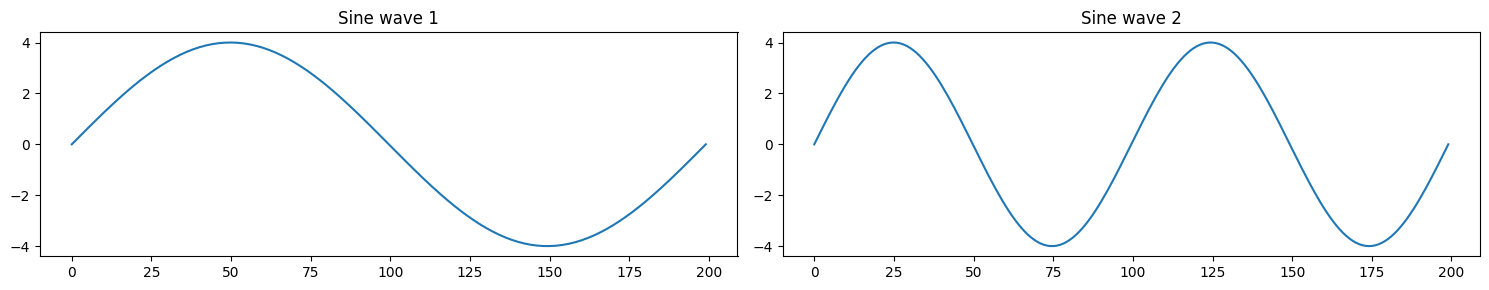

In [ ]:
# plot the signals
num_signals = len(signals)
fig, axs = plt.subplots(1, num_signals, figsize=(15, 3))

for i, (signal_name, signal) in enumerate(signals.items()):
    axs[i % num_signals].plot(signal)
    axs[i % num_signals].set_title(signal_name)

plt.tight_layout()
plt.show()

In [ ]:
# calculate fc matrices for awake participants
awake_participants_fcs = torch.empty(num_wake, 80, 80)
awake_data = reconstructed_wake

for i in range(num_wake):
    participant_data_tensor = awake_data[i]
    fc = compute_fc_matrix_regular(participant_data_tensor, num_brain_nodes=80)
    awake_participants_fcs[i] = fc

In [ ]:
# calculate fc matrices for N3 participants
n3_participants_fcs = torch.empty(num_n3, 80, 80)
n3_data = reconstructed_n3

for i in range(num_n3):
    participant_data_tensor = n3_data[i]
    fc = compute_fc_matrix_regular(participant_data_tensor, num_brain_nodes=80)
    n3_participants_fcs[i] = fc

In [ ]:
awake_participants_fcs.shape, n3_participants_fcs.shape

(torch.Size([11, 80, 80]), torch.Size([11, 80, 80]))

In [ ]:
def calculate_ssims(perturbed_fc, comparison_fcs):
    ssims = []

    for i in range(comparison_fcs.shape[0]):
        ssim_value = ssim(perturbed_fc.detach().numpy(), comparison_fcs[i].detach().numpy(), data_range=2)
        ssims.append(ssim_value)

    return np.mean(ssims)

def calculate_corrs(perturbed_fc, comparison_fcs):
    corrs = []

    for i in range(comparison_fcs.shape[0]):
        correlation = torch.corrcoef(torch.stack([perturbed_fc.view(-1), comparison_fcs[i].view(-1)]))[0, 1]
        corrs.append(correlation)

    return np.mean(corrs)

def apply_perturbation(latent_data, signal, region):
    perturbed_data = latent_data.clone()
    perturbed_data[:, region] += signal
    return perturbed_data

In [ ]:
def loss_function(decoded_fc, decoded_fc_original, awake_fcs, n3_fcs):
    # ssim_awake = calculate_ssims(decoded_fc, awake_fcs)
    # ssim_n3 = calculate_ssims(decoded_fc, n3_fcs)
    corr_awake = calculate_corrs(decoded_fc, awake_fcs)
    corr_n3 = calculate_corrs(decoded_fc, n3_fcs)

    # loss = - (np.mean(ssim_awake) + np.mean(corr_awake)) + (np.mean(ssim_n3) + np.mean(corr_n3))
    loss = - (corr_awake) + (corr_n3)
    return loss

def optimized_signal(latent_data, decoded_fc_original, region, awake_fcs, n3_fcs):
    best_signal = None
    best_loss = float('inf')
    
    for freq in np.linspace(0.05, 1.0, 20):
        for amp in np.linspace(0.1, 2.0, 10):
            signal = amp * torch.sin(2 * np.pi * freq * torch.linspace(0, 1, num_time_points) * 10)
            perturbed_data = apply_perturbation(latent_data, signal, region)
            decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))
            decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

            loss = loss_function(decoded_fc, decoded_fc_original, awake_fcs, n3_fcs)
            if loss < best_loss:
                best_loss = loss
                best_signal = signal

    return best_signal

In [ ]:
def compute_baseline_metrics(fc_matrices):
    ssims = []
    corrs = []
    
    for i in range(len(fc_matrices)):
        for j in range(i+1, len(fc_matrices)):
            ssim_value = ssim(fc_matrices[i].detach().numpy(), fc_matrices[j].detach().numpy(), data_range=2)
            correlation = torch.corrcoef(torch.stack([fc_matrices[i].view(-1), fc_matrices[j].view(-1)]))[0, 1]
            
            ssims.append(ssim_value)
            corrs.append(correlation)
    
    return np.mean(ssims), np.std(ssims), np.mean(corrs), np.std(corrs)

def normalize_metrics(value, baseline_mean, baseline_std):
    return (value - baseline_mean) / baseline_std

In [ ]:
baseline_awake_ssim_mean, baseline_awake_ssim_std, baseline_awake_corr_mean, baseline_awake_corr_std = compute_baseline_metrics(awake_participants_fcs)
baseline_n3_ssim_mean, baseline_n3_ssim_std, baseline_n3_corr_mean, baseline_n3_corr_std = compute_baseline_metrics(n3_participants_fcs)

In [ ]:
total_regions = {f"{i+1}": {} for i in range(latent_dimension)}

for region in range(latent_dimension):
    print(f"Latent regions: {region + 1}")

    ssim_w = []
    ssim_n3 = []
    corrs_w = []
    corrs_n3 = []
    closer_to_awake = []
    predictions = []
    best_signals = []

    for participant in range(num_n3):
        print(f"Participant {participant + 1}")

        decoded_data_original = model.decoder(latent_n3_data[participant].view(-1, latent_dimension))
        decoded_fc_original = compute_fc_matrix_regular(decoded_data_original.view(num_time_points, num_brain_nodes), num_brain_nodes=80)
        
        # Optimize the signal
        best_signal = optimized_signal(latent_n3_data[participant], decoded_fc_original, region, awake_participants_fcs, n3_participants_fcs)
        
        # Apply perturbation and decode data
        perturbed_data = apply_perturbation(latent_n3_data[participant], best_signal, region)
        decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))

        # Compute FC matrices
        decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

        # Calculate SSIM and correlation metrics
        mean_ssims_w = calculate_ssims(decoded_fc, awake_participants_fcs)
        mean_ssims_w_og = calculate_ssims(decoded_fc_original, awake_participants_fcs)
        mean_ssims_n3 = calculate_ssims(decoded_fc, n3_participants_fcs)
        mean_ssims_n3_og = calculate_ssims(decoded_fc_original, n3_participants_fcs)

        mean_corrs_w = calculate_corrs(decoded_fc, awake_participants_fcs)
        mean_corrs_w_og = calculate_corrs(decoded_fc_original, awake_participants_fcs)
        mean_corrs_n3 = calculate_corrs(decoded_fc, n3_participants_fcs)
        mean_corrs_n3_og = calculate_corrs(decoded_fc_original, n3_participants_fcs)

        # Normalize using baseline metrics
        normalized_ssim_w = normalize_metrics(mean_ssims_w, baseline_awake_ssim_mean, baseline_awake_ssim_std)
        normalized_ssim_n3 = normalize_metrics(mean_ssims_n3, baseline_n3_ssim_mean, baseline_n3_ssim_std)
        normalized_corr_w = normalize_metrics(mean_corrs_w, baseline_awake_corr_mean, baseline_awake_corr_std)
        normalized_corr_n3 = normalize_metrics(mean_corrs_n3, baseline_n3_corr_mean, baseline_n3_corr_std)

        # Normalize SSIM and correlation metrics relative to original states
        ssim_normalized_w = normalized_ssim_w / normalize_metrics(mean_ssims_w_og, baseline_awake_ssim_mean, baseline_awake_ssim_std)
        ssim_normalized_n3 = normalized_ssim_n3 / normalize_metrics(mean_ssims_n3_og, baseline_n3_ssim_mean, baseline_n3_ssim_std)
        corrs_normalized_w = normalized_corr_w / normalize_metrics(mean_corrs_w_og, baseline_awake_corr_mean, baseline_awake_corr_std)
        corrs_normalized_n3 = normalized_corr_n3 / normalize_metrics(mean_corrs_n3_og, baseline_n3_corr_mean, baseline_n3_corr_std)

        # Check if perturbed state is closer to awake than to original N3
        # closer_to_w_than_n3 = ssim_normalized_w > ssim_normalized_n3 and corrs_normalized_w > corrs_normalized_n3
        closer_to_w_than_n3 = corrs_normalized_w > corrs_normalized_n3
        
        print(f"SSIM Awake: {mean_ssims_w}")
        print(f"SSIM N3: {mean_ssims_n3}")
        print(f"Correlation Awake: {mean_corrs_w}")
        print(f"Correlation N3: {mean_corrs_n3}")
        print(f"SSIM Awake Normalized: {ssim_normalized_w}")
        print(f"SSIM N3 Normalized: {ssim_normalized_n3}")
        print(f"Correlation Awake Normalized: {corrs_normalized_w}")
        print(f"Correlation N3 Normalized: {corrs_normalized_n3}")
        print(f"Closer to Awake: {closer_to_w_than_n3}")

        ssim_w.append(ssim_normalized_w)
        ssim_n3.append(ssim_normalized_n3)
        corrs_w.append(corrs_normalized_w)
        corrs_n3.append(corrs_normalized_n3)
        closer_to_awake.append(closer_to_w_than_n3)
        best_signals.append(best_signal)

        # Classification of reconstructed FC matrices
        perturbed_lower_triangle = utils.extract_lower_triangle(decoded_fc)
        n3_lower_triangle = utils.extract_lower_triangle(n3_participants_fcs[participant])
        awake_lower_triangle = utils.extract_lower_triangle(awake_participants_fcs[participant])

        pred = classifier_reconstructed.predict([perturbed_lower_triangle, n3_lower_triangle, awake_lower_triangle])
        predictions.append(pred)
        pred = ['N3' if x == 1 else 'W *' for x in pred]

        print(f"Classifications: (perturbed) {pred[0]} | (N3) {pred[1]} | (Awake) {pred[2]}")
        print()

    total_regions[f"{region + 1}"]['SSIM Awake'] = ssim_w
    total_regions[f"{region + 1}"]['SSIM N3'] = ssim_n3
    total_regions[f"{region + 1}"]['Correlation Awake'] = corrs_w
    total_regions[f"{region + 1}"]['Correlation N3'] = corrs_n3
    total_regions[f"{region + 1}"]['Closer to Awake'] = closer_to_awake
    total_regions[f"{region + 1}"]['Predictions'] = predictions
    total_regions[f"{region + 1}"]['Best Signals'] = best_signals

total_signals = total_regions

Latent regions: 1
Participant 1
SSIM Awake: 0.16444976550017862
SSIM N3: 0.2093296975350384
Correlation Awake: 0.23641513288021088
Correlation N3: 0.26900261640548706
SSIM Awake Normalized: 4.103406391684638
SSIM N3 Normalized: -7.399619359030417
Correlation Awake Normalized: 2.6999003887176514
Correlation N3 Normalized: 19.530439376831055
Closer to Awake: False
Classifications: (perturbed) N3 | (N3) N3 | (Awake) W *

Participant 2
SSIM Awake: 0.1529583819135156
SSIM N3: 0.2116610266848114
Correlation Awake: 0.30170395970344543
Correlation N3: 0.344814658164978
SSIM Awake Normalized: 10.729247793060713
SSIM N3 Normalized: -2.3425286101978577
Correlation Awake Normalized: 3.6322858333587646
Correlation N3 Normalized: -1.7666555643081665
Closer to Awake: True
Classifications: (perturbed) N3 | (N3) N3 | (Awake) N3

Participant 3
SSIM Awake: 0.15847336407632476
SSIM N3: 0.21374396109845728
Correlation Awake: 0.3204669654369354
Correlation N3: 0.35560381412506104
SSIM Awake Normalized: -18.

KeyboardInterrupt: 

In [ ]:
# find best performing region where most 
best_region = None

for region in total_regions:
    if best_region is None:
        best_region = region
    else:
        # count where most correlation awake participants is > 0
        count = np.sum(np.array(total_regions[region]['Correlation Awake']) > 0)
        best_count = np.sum(np.array(total_regions[best_region]['Correlation Awake']) > 0)

        if count > best_count:
            best_region = region
        
print(f"Best region: {best_region}")

Best region: 3


In [ ]:
# calculate % of woken up participants in best region
woken_up = np.mean(total_regions[best_region]['Closer to Awake']) * 100
print(f"% of woken up participants: {woken_up}")

% of woken up participants: 72.72727272727273


In [ ]:
# calculate correlations of original data with awake
corrs_original_awake = []

for i in range(num_n3):
    corrs_original_awake.append(calculate_corrs(n3_participants_fcs[i], awake_participants_fcs))

# normalize the correlation of original data with awake
corrs_original_awake_normalized = normalize_metrics(corrs_original_awake, baseline_awake_corr_mean, baseline_awake_corr_std)
print(f"Normalized correlation of original data with awake: {corrs_original_awake_normalized}")

Normalized correlation of original data with awake: [-0.6262543  -0.2994155   0.39643723 -0.38230497  0.03240749 -0.24316262
 -0.03953077  0.17583212  0.38008934 -0.12465926 -0.25301507]


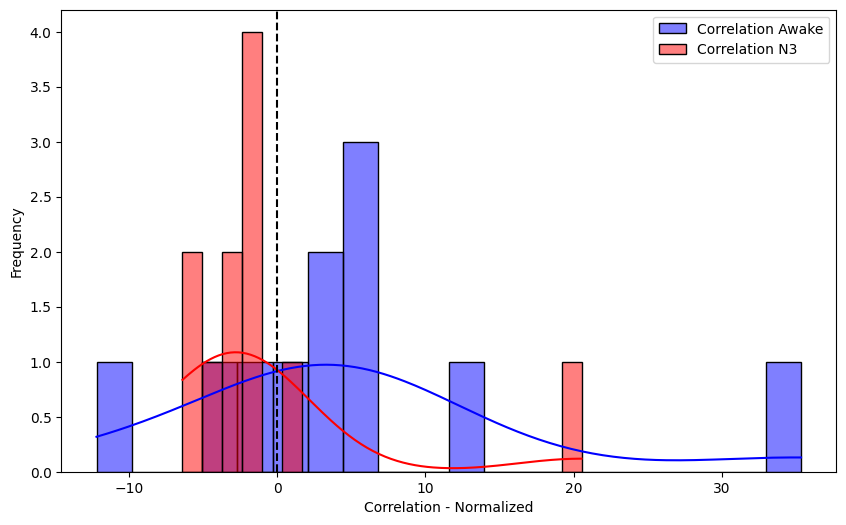

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(total_signals[best_region]['Correlation Awake'], color='blue', kde=True, label='Correlation Awake', bins=20)
sns.histplot(total_signals[best_region]['Correlation N3'], color='red', kde=True, label='Correlation N3', bins=20)
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Correlation - Normalized')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
corrs_best_signal = np.array(total_signals[best_region]['Correlation Awake'])
corrs_best_signal_n3 = np.array(total_signals[best_region]['Correlation N3'])

corrs_best_ttest = ttest_ind(corrs_best_signal, corrs_best_signal_n3)

corrs_best_ttest

TtestResult(statistic=1.3980331767896013, pvalue=0.17741653307219643, df=20.0)

In [ ]:
total_signals = {key: {} for key in signals.keys()}
total_regions = {
    f"{i+1}": {} for i in range(latent_dimension)
}

for key, signal in signals.items():
    print(f"Signal: {key}")
    print("---------------")
    for region in range(latent_dimension):
            print(f"Latent regions: {region + 1}")

            ssim_w = []
            ssim_n3 = []
            corrs_w = []
            corrs_n3 = []
            closer_to_awake = []
            predictions = []

            for participant in range(num_n3):
                # Apply perturbation and decode data
                # best_signal = optimized_signal(latent_n3_data[participant], region, awake_participants_fcs, n3_participants_fcs)
                # perturbed_data = apply_perturbation(latent_n3_data[participant], best_signal, region)
                perturbed_data = apply_perturbation(latent_n3_data[participant], signal, region)
                decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))
                decoded_data_original = model.decoder(latent_n3_data[participant].view(-1, latent_dimension))

                # Compute FC matrices
                decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)
                decoded_fc_original = compute_fc_matrix_regular(decoded_data_original.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

                # Inside your main loop
                mean_ssims_w = calculate_ssims(decoded_fc, awake_participants_fcs)
                mean_ssims_w_og = calculate_ssims(decoded_fc_original, awake_participants_fcs)
                mean_ssims_n3 = calculate_ssims(decoded_fc, n3_participants_fcs)
                mean_ssims_n3_og = calculate_ssims(decoded_fc_original, n3_participants_fcs)

                mean_corrs_w = calculate_corrs(decoded_fc, awake_participants_fcs)
                mean_corrs_w_og = calculate_corrs(decoded_fc_original, awake_participants_fcs)
                mean_corrs_n3 = calculate_corrs(decoded_fc, n3_participants_fcs)
                mean_corrs_n3_og = calculate_corrs(decoded_fc_original, n3_participants_fcs)

                # Normalize using baseline metrics
                normalized_ssim_w = normalize_metrics(mean_ssims_w, baseline_awake_ssim_mean, baseline_awake_ssim_std)
                normalized_ssim_n3 = normalize_metrics(mean_ssims_n3, baseline_n3_ssim_mean, baseline_n3_ssim_std)
                normalized_corr_w = normalize_metrics(mean_corrs_w, baseline_awake_corr_mean, baseline_awake_corr_std)
                normalized_corr_n3 = normalize_metrics(mean_corrs_n3, baseline_n3_corr_mean, baseline_n3_corr_std)

                # Normalize SSIM and correlation metrics relative to original states
                ssim_normalized_w = normalized_ssim_w / normalize_metrics(mean_ssims_w_og, baseline_awake_ssim_mean, baseline_awake_ssim_std)
                ssim_normalized_n3 = normalized_ssim_n3 / normalize_metrics(mean_ssims_n3_og, baseline_n3_ssim_mean, baseline_n3_ssim_std)
                corrs_normalized_w = normalized_corr_w / normalize_metrics(mean_corrs_w_og, baseline_awake_corr_mean, baseline_awake_corr_std)
                corrs_normalized_n3 = normalized_corr_n3 / normalize_metrics(mean_corrs_n3_og, baseline_n3_corr_mean, baseline_n3_corr_std)

                # Check if perturbed state is closer to awake than to original N3
                # closer => ssim of perturbed with awake fc > ssim of perturbed with N3 fc 
                # and correlation of perturbed with awake fc > correlation of perturbed with N3 fc
                closer_to_w_than_n3 = ssim_normalized_w > ssim_normalized_n3 and corrs_normalized_w > corrs_normalized_n3
                
                print(f"Participant {participant + 1}")
                print(f"SSIM Awake: {mean_ssims_w}")
                print(f"SSIM N3: {mean_ssims_n3}")
                print(f"Correlation Awake: {mean_corrs_w}")
                print(f"Correlation N3: {mean_corrs_n3}")
                print(f"SSIM Awake Normalized: {ssim_normalized_w}")
                print(f"SSIM N3 Normalized: {ssim_normalized_n3}")
                print(f"Correlation Awake Normalized: {corrs_normalized_w}")
                print(f"Correlation N3 Normalized: {corrs_normalized_n3}")
                print(f"Closer to Awake: {closer_to_w_than_n3}")

                ssim_w.append(ssim_normalized_w)
                ssim_n3.append(ssim_normalized_n3)
                corrs_w.append(corrs_normalized_w)
                corrs_n3.append(corrs_normalized_n3)
                closer_to_awake.append(closer_to_w_than_n3)

                # Classification of reconstructed FC matrices
                perturbed_lower_triangle = utils.extract_lower_triangle(decoded_fc)
                n3_lower_triangle = utils.extract_lower_triangle(n3_participants_fcs[participant])
                awake_lower_triangle = utils.extract_lower_triangle(awake_participants_fcs[participant])

                pred = classifier_reconstructed.predict([perturbed_lower_triangle, n3_lower_triangle, awake_lower_triangle])
                predictions.append(pred)
                pred = ['N3' if x == 1 else 'W *' for x in pred]

                print(f"Classifications: (perturbed) {pred[0]} | (N3) {pred[1]} | (Awake) {pred[2]}")
                print()

            total_regions[f"{region + 1}"]['SSIM Awake'] = ssim_w
            total_regions[f"{region + 1}"]['SSIM N3'] = ssim_n3
            total_regions[f"{region + 1}"]['Correlation Awake'] = corrs_w
            total_regions[f"{region + 1}"]['Correlation N3'] = corrs_n3
            total_regions[f"{region + 1}"]['Closer to Awake'] = closer_to_awake
            total_regions[f"{region + 1}"]['Predictions'] = predictions

    total_signals[key] = total_regions

Signal: Sine wave 1
---------------
Latent regions: 1
Participant 1
SSIM Awake: 0.31260717369229557
SSIM N3: 0.4234151215527773
Correlation Awake: 0.3562573492527008
Correlation N3: 0.44816482067108154
SSIM Awake Normalized: 0.930931472848574
SSIM N3 Normalized: 1.1708765214169832
Correlation Awake Normalized: 0.9317227005958557
Correlation N3 Normalized: 0.4969019889831543
Closer to Awake: False
Classifications: (perturbed) N3 | (N3) N3 | (Awake) W *

Participant 2
SSIM Awake: 0.34029766913213727
SSIM N3: 0.4746053474834207
Correlation Awake: 0.39069250226020813
Correlation N3: 0.5168678760528564
SSIM Awake Normalized: 0.8337729686457063
SSIM N3 Normalized: 1.0324474534919263
Correlation Awake Normalized: 0.8861209154129028
Correlation N3 Normalized: 1.0470613241195679
Closer to Awake: False
Classifications: (perturbed) N3 | (N3) N3 | (Awake) N3

Participant 3
SSIM Awake: 0.3644528056643303
SSIM N3: 0.49558677085374364
Correlation Awake: 0.4604603946208954
Correlation N3: 0.5628416538

In [ ]:
# print percentage of participants closer to awake than to N3 for each signal and region
total_percentages = []

for key, signal in total_signals.items():
    print(f"Signal: {key}")
    print("---------------")
    for regions, metrics in signal.items():
        print(f"Regions: {regions}")
        print(f"Percentage of participants closer to Awake: {np.mean(metrics['Closer to Awake']) * 100}%")
        print()

        total_percentages.append(np.mean(metrics['Closer to Awake']) * 100)

Signal: Sine wave 1
---------------
Regions: 1
Percentage of participants closer to Awake: 27.27272727272727%

Regions: 2
Percentage of participants closer to Awake: 36.36363636363637%

Regions: 3
Percentage of participants closer to Awake: 27.27272727272727%

Regions: 4
Percentage of participants closer to Awake: 18.181818181818183%

Regions: 5
Percentage of participants closer to Awake: 18.181818181818183%

Regions: 6
Percentage of participants closer to Awake: 18.181818181818183%

Regions: 7
Percentage of participants closer to Awake: 0.0%

Regions: 8
Percentage of participants closer to Awake: 9.090909090909092%

Regions: 9
Percentage of participants closer to Awake: 27.27272727272727%

Regions: 10
Percentage of participants closer to Awake: 18.181818181818183%

Regions: 11
Percentage of participants closer to Awake: 45.45454545454545%

Regions: 12
Percentage of participants closer to Awake: 27.27272727272727%

Regions: 13
Percentage of participants closer to Awake: 27.272727272727

Text(0.5, 1.0, 'Percentage of participants closer to Awake than to N3')

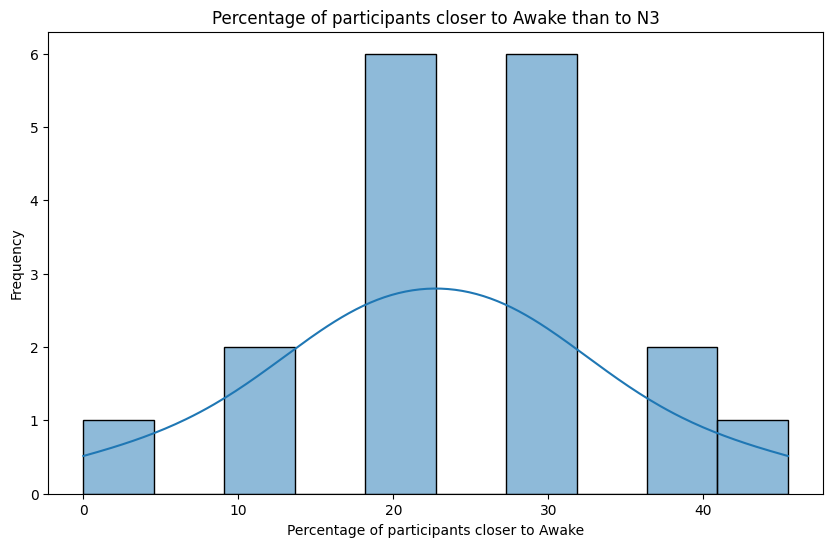

In [ ]:
# plot percentage of participants closer to awake than to N3 for each signal and region
plt.figure(figsize=(10, 6))
sns.histplot(total_percentages, bins=10, kde=True)
plt.xlabel('Percentage of participants closer to Awake')
plt.ylabel('Frequency')
plt.title('Percentage of participants closer to Awake than to N3')

In [ ]:
# find the signal and region that maximizes the percentage of participants where perturbed state is closer to awake than to original N3
max_percentage = 0
max_signal = None
max_region = None

for key, signal in total_signals.items():
    for regions, metrics in signal.items():
        percentage = np.mean(metrics['Closer to Awake']) * 100

        if percentage > max_percentage:
            max_percentage = percentage
            max_signal = key
            max_region = regions

print(f"Signal: {max_signal}")
print(f"Region: {max_region}")
print(f"Percentage of participants closer to Awake: {max_percentage}%")

Signal: Sine wave 1
Region: 11
Percentage of participants closer to Awake: 45.45454545454545%


In [ ]:
max_participants = 0
max_signal = None
max_region = None

for signal, regions in total_signals.items():
    for region, data in regions.items():
        ssim_w = data['SSIM Awake']
        ssim_n3 = data['SSIM N3']
        corrs_w = data['Correlation Awake']
        corrs_n3 = data['Correlation N3']
        
        num_participants = 0
        for i in range(len(ssim_w)):
            # if ssim_w[i] > 1 and ssim_n3[i] < 1 and corrs_w[i] > 1 and corrs_n3[i] < 1:
            if ssim_w[i] > 1 and corrs_w[i] > 1:
                num_participants += 1

        if num_participants > max_participants:
            max_participants = num_participants
            max_signal = signal
            max_region = region

max_participants, max_signal, max_region

(6, 'Sine wave 1', '11')

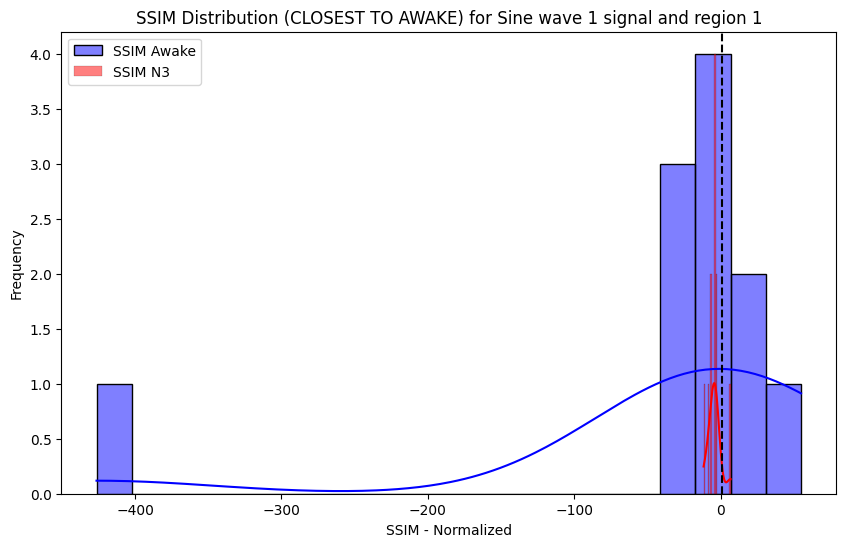

In [ ]:
# plot ssim distribution for the signal and region that maximizes the percentage of participants where perturbed state is closer to awake than to original N3
plt.figure(figsize=(10, 6))
plt.title(f'SSIM Distribution (CLOSEST TO AWAKE) for {max_signal} signal and region {max_region}')
sns.histplot(total_signals[max_signal][max_region]['SSIM Awake'], color='blue', kde=True, label='SSIM Awake', bins=20)
sns.histplot(total_signals[max_signal][max_region]['SSIM N3'], color='red', kde=True, label='SSIM N3', bins=20)
plt.axvline(x=1, color='black', linestyle='--')
plt.xlabel('SSIM - Normalized')
plt.ylabel('Frequency')
plt.legend()

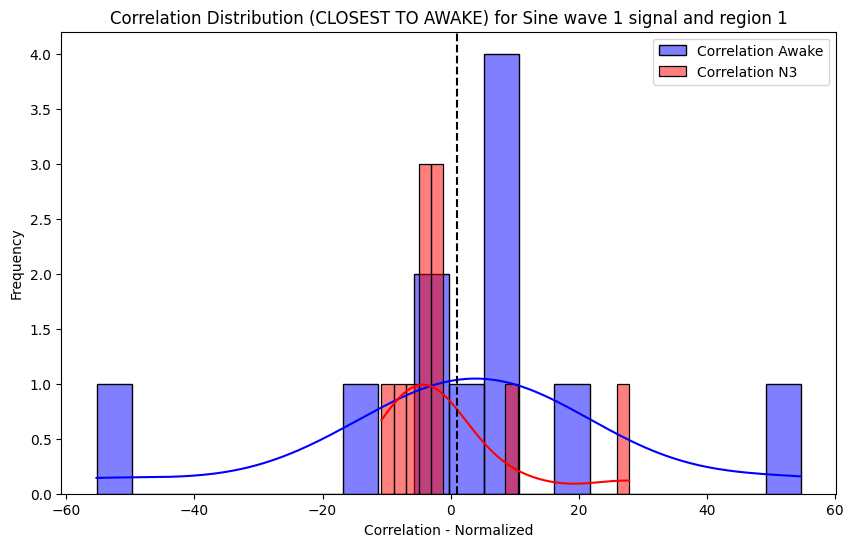

In [ ]:
# plot correlation distribution for the signal and region that maximizes the percentage of participants where perturbed state is closer to awake than to original N3
plt.figure(figsize=(10, 6))
plt.title(f'Correlation Distribution (CLOSEST TO AWAKE) for {max_signal} signal and region {max_region}')
sns.histplot(total_signals[max_signal][max_region]['Correlation Awake'], color='blue', kde=True, label='Correlation Awake', bins=20)
sns.histplot(total_signals[max_signal][max_region]['Correlation N3'], color='red', kde=True, label='Correlation N3', bins=20)
plt.axvline(x=1, color='black', linestyle='--')
plt.xlabel('Correlation - Normalized')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
# calculate statistical significance of the difference in SSIM and correlation between perturbed state with awake and N3 FC matrices for the best signal and region
ssim_best_signal = np.array(total_signals[max_signal][max_region]['SSIM Awake'])
ssim_best_n3 = np.array(total_signals[max_signal][max_region]['SSIM N3'])
corrs_best_signal = np.array(total_signals[max_signal][max_region]['Correlation Awake'])
corrs_best_n3 = np.array(total_signals[max_signal][max_region]['Correlation N3'])

ssim_best_ttest = ttest_ind(ssim_best_signal, ssim_best_n3)
corrs_best_ttest = ttest_ind(corrs_best_signal, corrs_best_n3)

ssim_best_ttest, corrs_best_ttest

(TtestResult(statistic=-0.8823003331477955, pvalue=0.38809604821740395, df=20.0),
 TtestResult(statistic=0.3675647003682176, pvalue=0.7170587997709994, df=20.0))

In [ ]:
# plot classification distribution and percentages
total_predictions = []
best_signal = None
best_region = None
best_percentage = 0

for key, signal in total_signals.items():
    print(f"Signal: {key}")
    print("---------------")
    for regions, metrics in signal.items():
        awake_perturbed_count = 0
        awake_real_count = 0
        n3_real_count = 0
        for participant in metrics['Predictions']:
            total_predictions.append(participant)
            
            if participant[2] == 0:
                awake_real_count += 1
            if participant[1] == 1:
                n3_real_count += 1
            if participant[0] == 0:
                awake_perturbed_count += 1
        
        print(f"Regions: {regions}")
        print(f"Percentage of perturbed* states classified as W: {awake_perturbed_count / num_n3 * 100}%")
        print(f"Percentage of real W states classified as W: {awake_real_count / num_n3 * 100}%")
        print(f"Percentage of real N3 states classified as W: {n3_real_count / num_n3 * 100}%")
        print()

        if awake_perturbed_count / num_n3 * 100 > best_percentage:
            best_percentage = awake_perturbed_count / num_n3 * 100
            best_signal = key
            best_region = regions

Signal: Sine wave 1
---------------
Regions: 1
Percentage of perturbed* states classified as W: 27.27272727272727%
Percentage of real W states classified as W: 90.9090909090909%
Percentage of real N3 states classified as W: 81.81818181818183%

Regions: 2
Percentage of perturbed* states classified as W: 27.27272727272727%
Percentage of real W states classified as W: 90.9090909090909%
Percentage of real N3 states classified as W: 81.81818181818183%

Regions: 3
Percentage of perturbed* states classified as W: 27.27272727272727%
Percentage of real W states classified as W: 90.9090909090909%
Percentage of real N3 states classified as W: 81.81818181818183%

Regions: 4
Percentage of perturbed* states classified as W: 27.27272727272727%
Percentage of real W states classified as W: 90.9090909090909%
Percentage of real N3 states classified as W: 81.81818181818183%

Regions: 5
Percentage of perturbed* states classified as W: 18.181818181818183%
Percentage of real W states classified as W: 90.9090

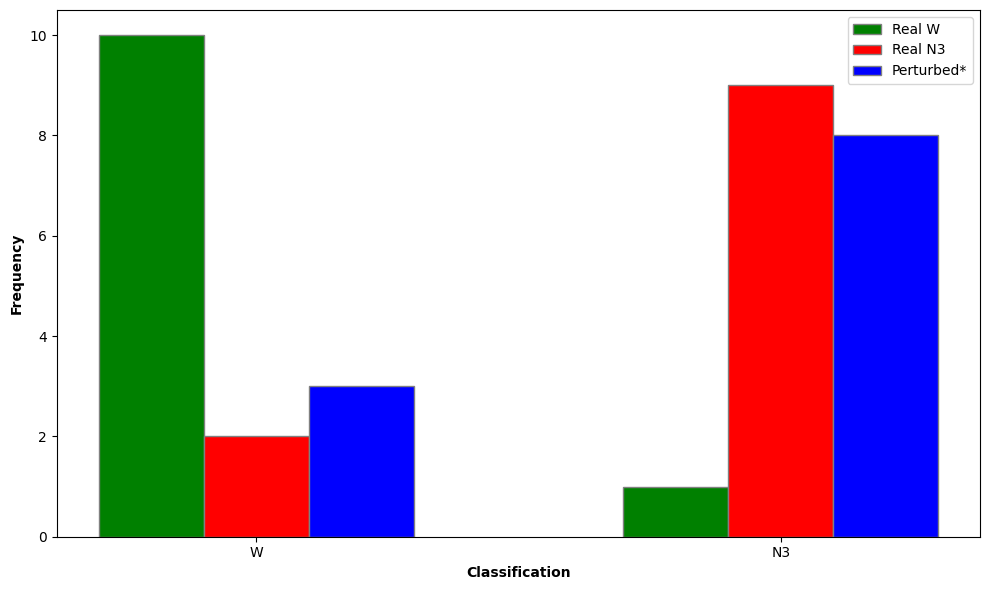

In [ ]:
best_signal_region_predictions = total_signals[best_signal][best_region]['Predictions']
best_signal_region_predictions_perturbed = [x[0] for x in best_signal_region_predictions]
best_signal_region_predictions_real_n3 = [x[1] for x in best_signal_region_predictions]
best_signal_region_predictions_real_w = [x[2] for x in best_signal_region_predictions]

# Define the classifications
classifications = [0, 1]

# Count frequencies for each classification
counts_real_w = [best_signal_region_predictions_real_w.count(cls) for cls in classifications]
counts_real_n3 = [best_signal_region_predictions_real_n3.count(cls) for cls in classifications]
counts_perturbed = [best_signal_region_predictions_perturbed.count(cls) for cls in classifications]

# Set the positions and width for the bars
bar_width = 0.2
r1 = np.arange(len(classifications))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(r1, counts_real_w, color='green', width=bar_width, edgecolor='grey', label='Real W')
plt.bar(r2, counts_real_n3, color='red', width=bar_width, edgecolor='grey', label='Real N3')
plt.bar(r3, counts_perturbed, color='blue', width=bar_width, edgecolor='grey', label='Perturbed*')

# Add labels
plt.xlabel('Classification', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(classifications))], ['W', 'N3'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

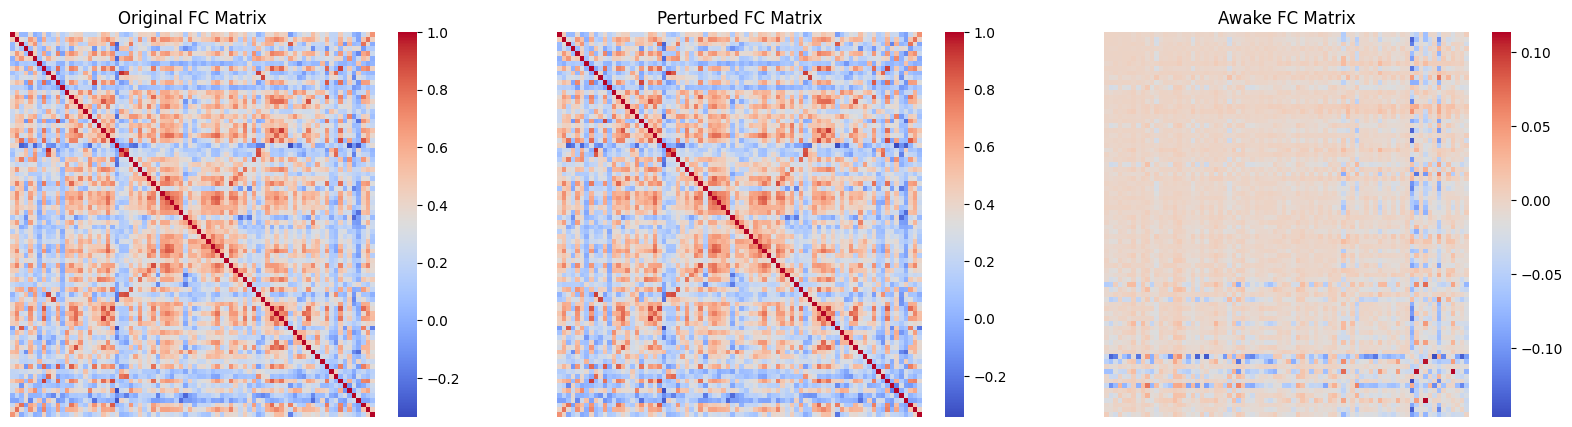

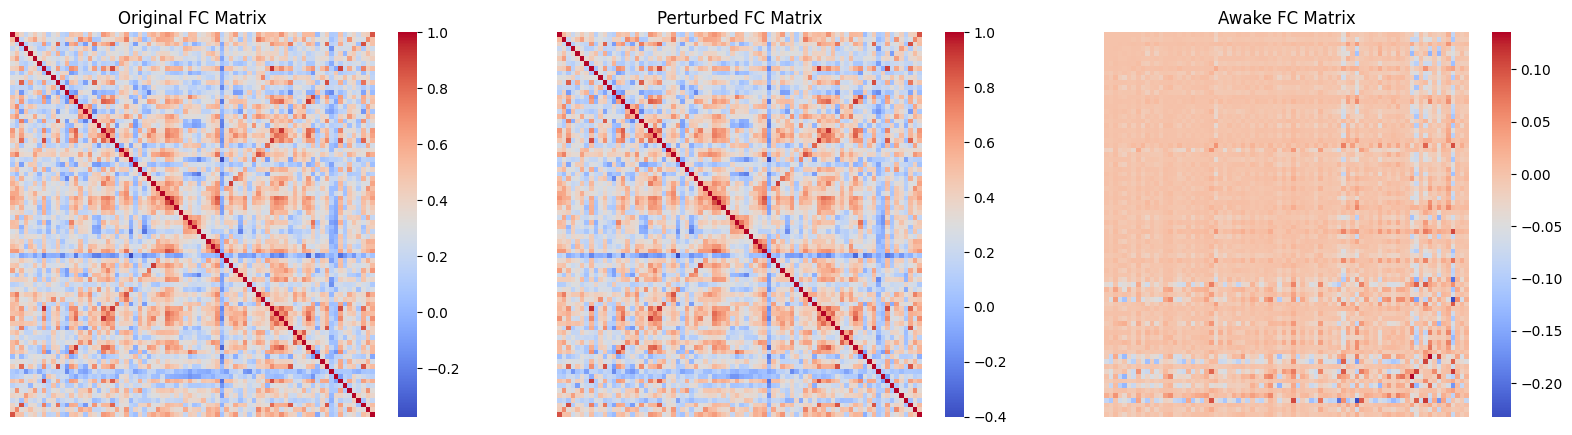

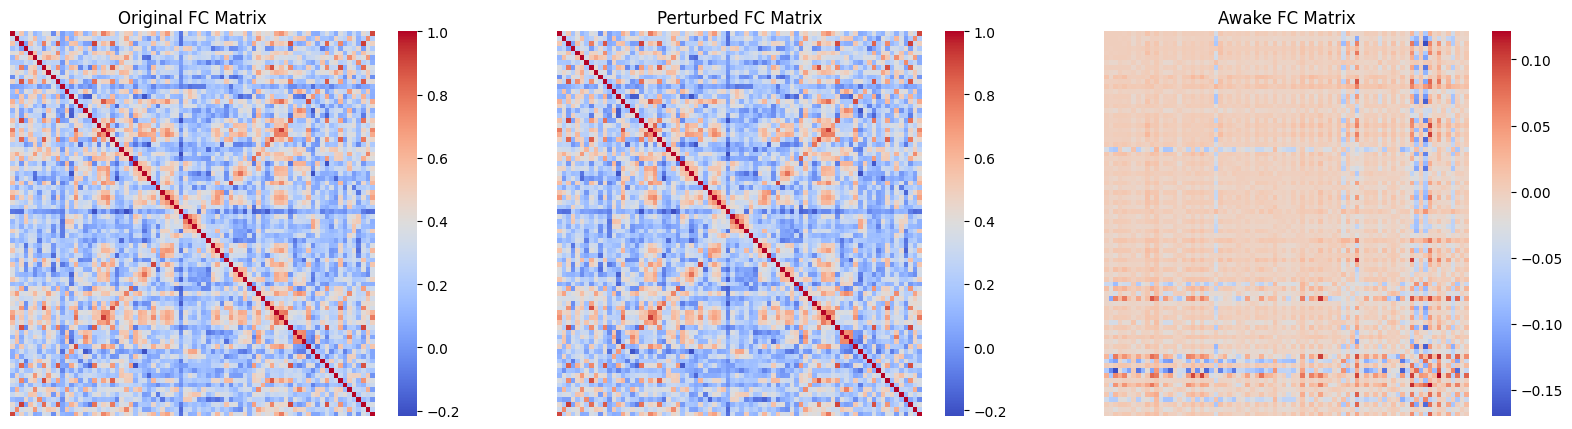

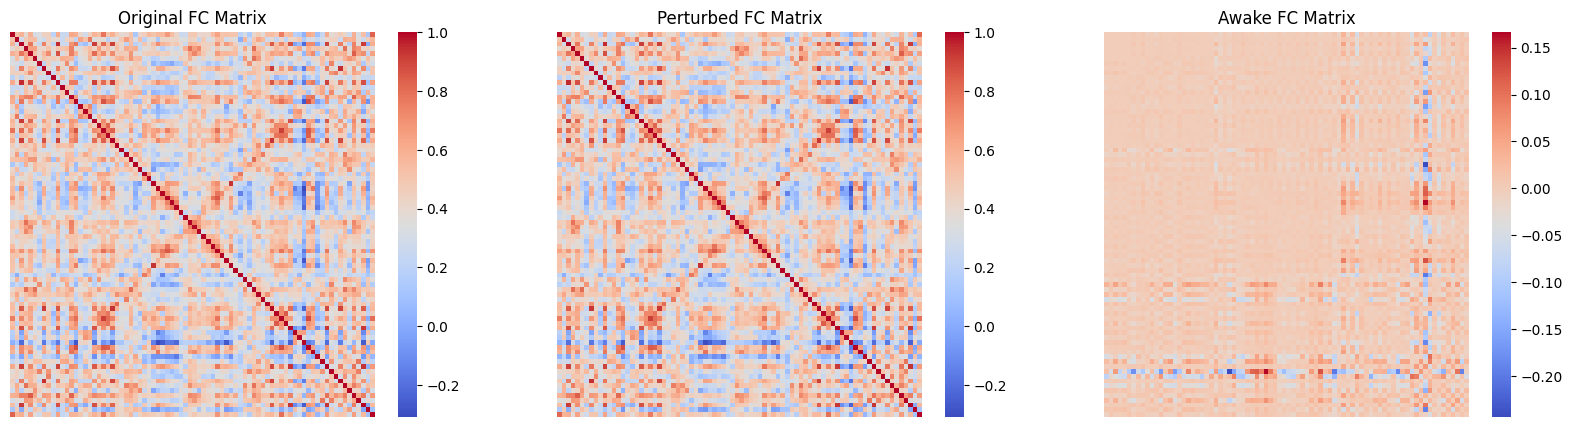

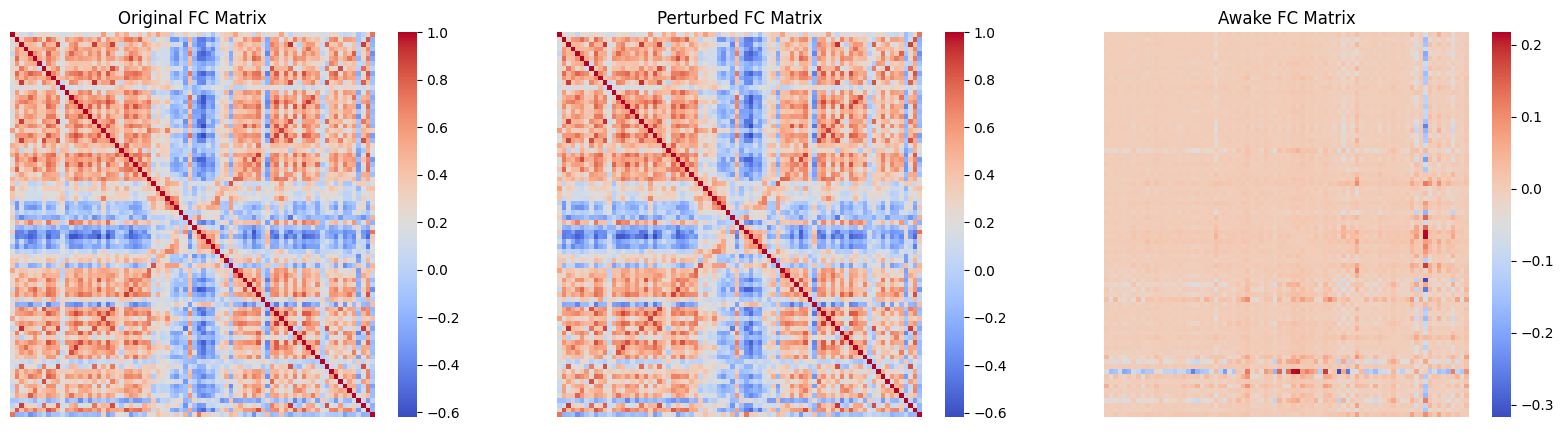

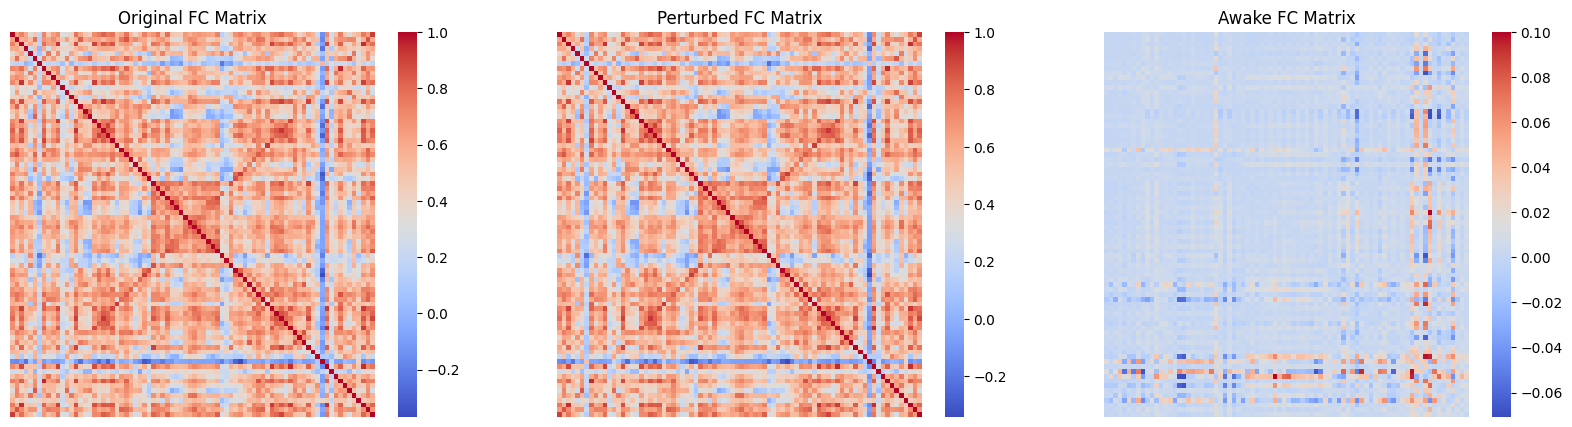

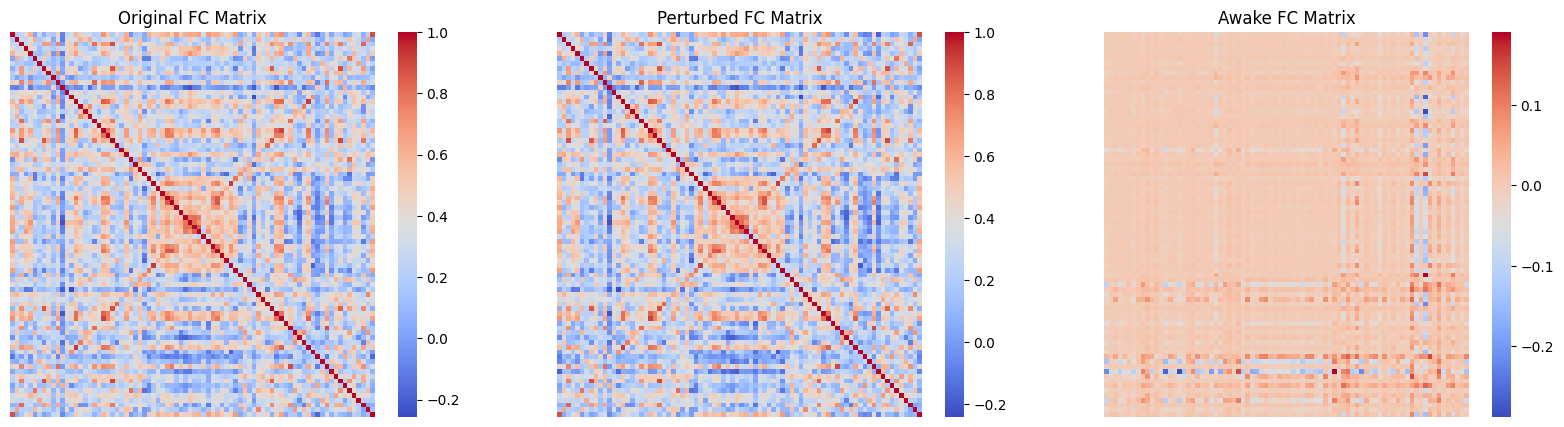

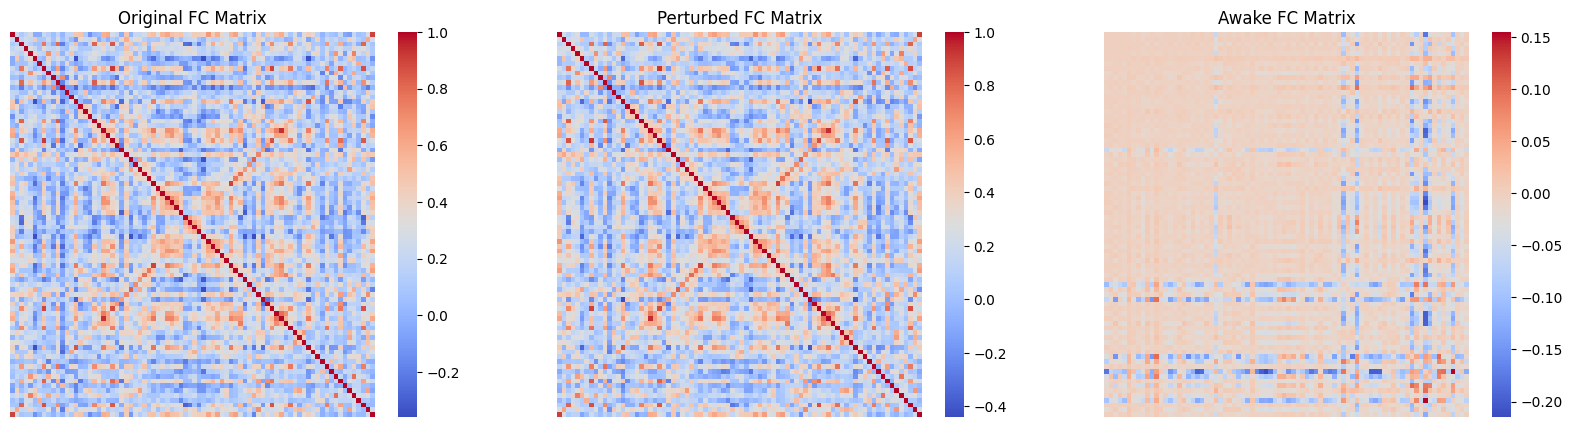

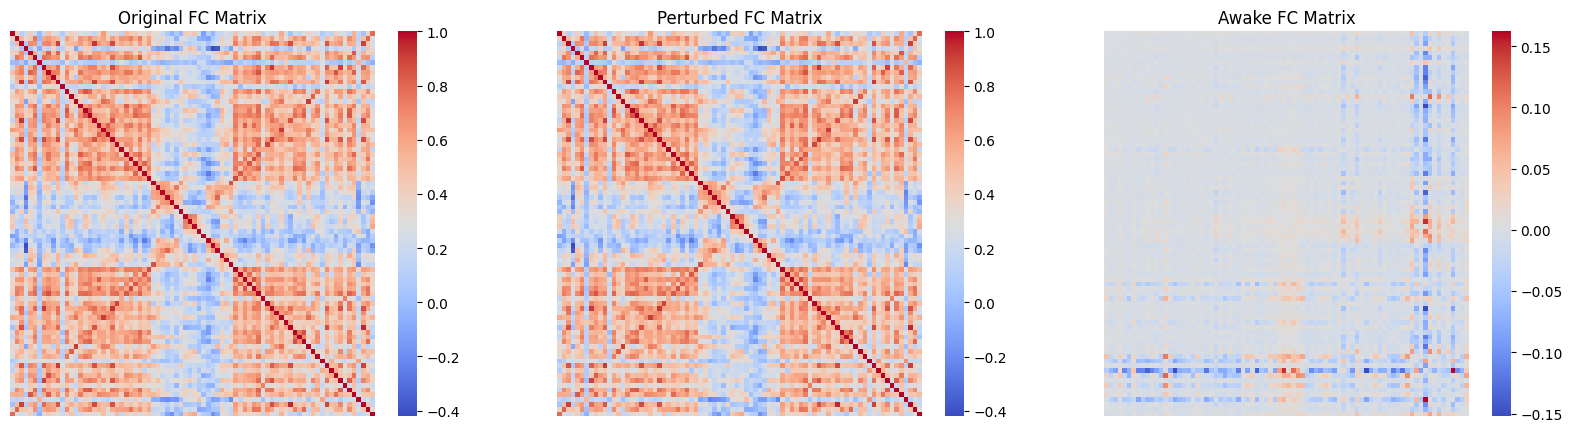

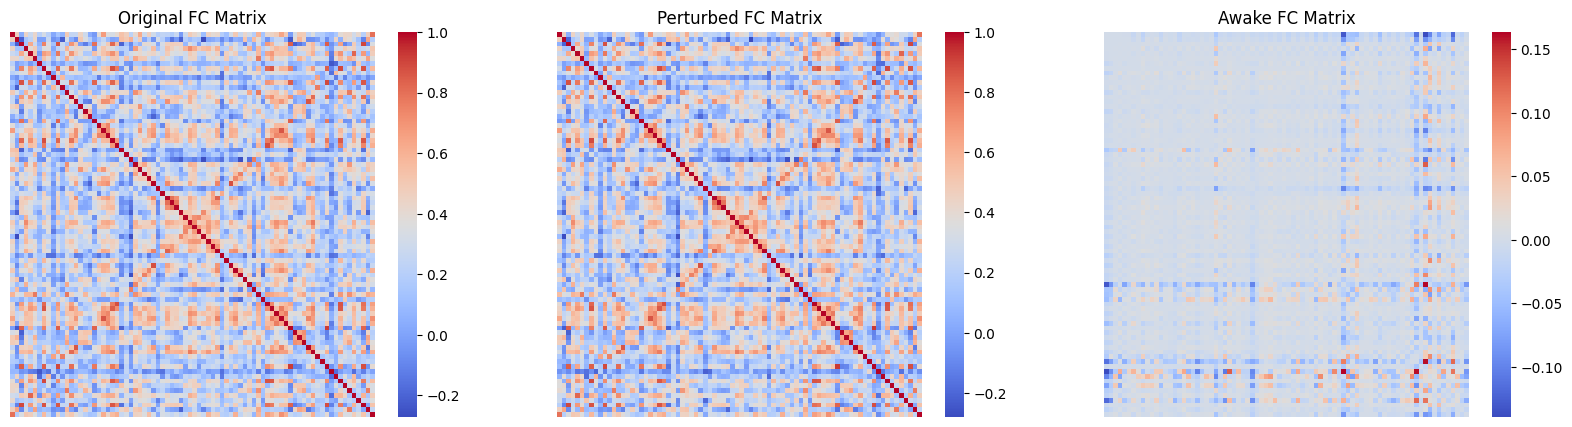

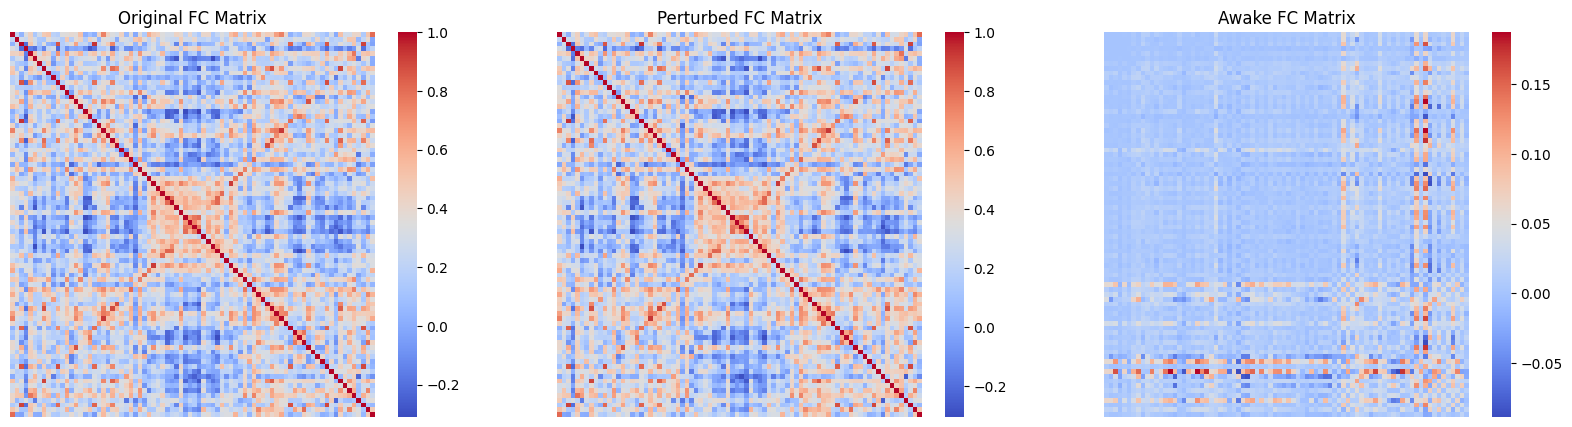

In [ ]:
# perform best signal and region and plot FC matrices
signal = signals[max_signal]
region = int(max_region) - 1

for participant in range(num_n3):
    sleeper = latent_n3_data[participant]
    perturbed_data = apply_perturbation(sleeper, signal, region)
    decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))
    decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)
    decoded_original = model.decoder(sleeper.view(-1, latent_dimension))
    decoded_fc_original = compute_fc_matrix_regular(decoded_original.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

    fc_diff = decoded_fc - decoded_fc_original

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(decoded_fc_original, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title('Original FC Matrix')
    plt.subplot(1, 3, 2)
    sns.heatmap(decoded_fc, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title('Perturbed FC Matrix')
    plt.subplot(1, 3, 3)
    sns.heatmap(fc_diff, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title('Awake FC Matrix')
    plt.show()